In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [20]:
""" Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
and m the nbr of datapoints from a python readout of the WLM. Check that each mesure has the amount of channel fixed by 
the first line and that there is no reset of the time (else compensate for it) """
def ReadDataPythonReadOut(path_name):
    with open(path_name, 'r') as file:
        Data = file.read()

    Data = Data.split("\n")

    # Initialize
    res = np.zeros((len(Data[0].split(" ")), len(Data)))
    try:
        res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
    except: # If error in reading (not everything is measured), return nothing
        print("Error initialization")
        return res
    
    time_offset = 0 # If time reinitialized, keep time increasing

    # Import the data line by line
    for i in range(1, len(Data)):
        try:
            res[:, i] = np.array(Data[i].split(" "), dtype=float)

            # Fix jumping time
            res[0, i] = res[0, i] + time_offset
            if res[0, i] < res[0, i-1]: # Time is not increasing
                time_offset = res[0, i-1] + np.mean(res[0, 1:i]-res[0, :i-1]) # Time reset -> offset = previous time + mean DeltaT
                res[0, i] = time_offset
                print("Time problem line "+str(i))

        except: # If error in reading (not everything is measured), put -1 for the time
            print("Error line "+str(i))
            res[0, i] = -1
    return res

In [21]:
# path_name = r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\Data17h_2025_09_29_Lambda_P_T_temp.txt"
path_name = r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\DataWeekend_2025_09_26_Lambda_P_T_temp.txt"
cutoff_std_lambda = 10 # Distance from mean above which data is absurd
# T, Lambda = ReadDataPythonReadOut(path_name)
# T, Lambda = T[T!=-1], Lambda[T!=-1]
T, Lambda, Pressure, Temperature = ReadDataPythonReadOut(path_name)
T, Lambda, Pressure, Temperature = T[T!=-1], Lambda[T!=-1], Pressure[T!=-1], Temperature[T!=-1] # Remove lines where every channel was not saved
Absurd_Lambda = np.abs(Lambda-np.mean(Lambda))<cutoff_std_lambda # Remove the data points where the wavelength distance from the mean is bigger than cutoff_std_lambda
T_clean, Lambda_clean, Pressure_clean, Temperature_clean = T[Absurd_Lambda], Lambda[Absurd_Lambda], Pressure[Absurd_Lambda], Temperature[Absurd_Lambda]

Time problem line 2055
Error line 1350555


# Plot evolution

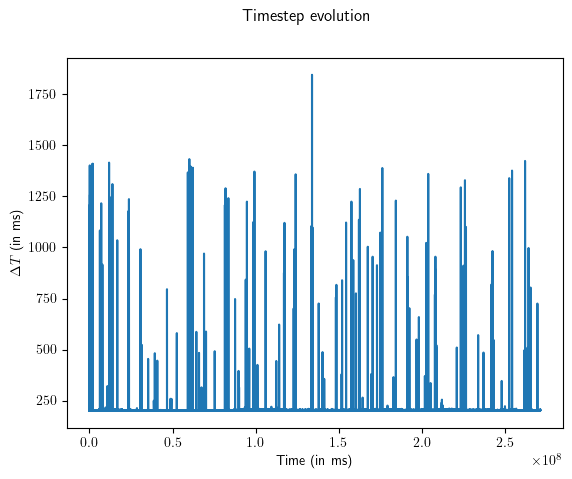

In [22]:
%matplotlib inline
plt.close()
plt.figure()
plt.plot(T[1:], T[1:]-T[0:-1])
plt.xlabel("Time (in ms)")
plt.ylabel(r"$\Delta T$ (in ms)")
plt.suptitle("Timestep evolution")
plt.show()

c:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\AnalyzeFrequencies\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


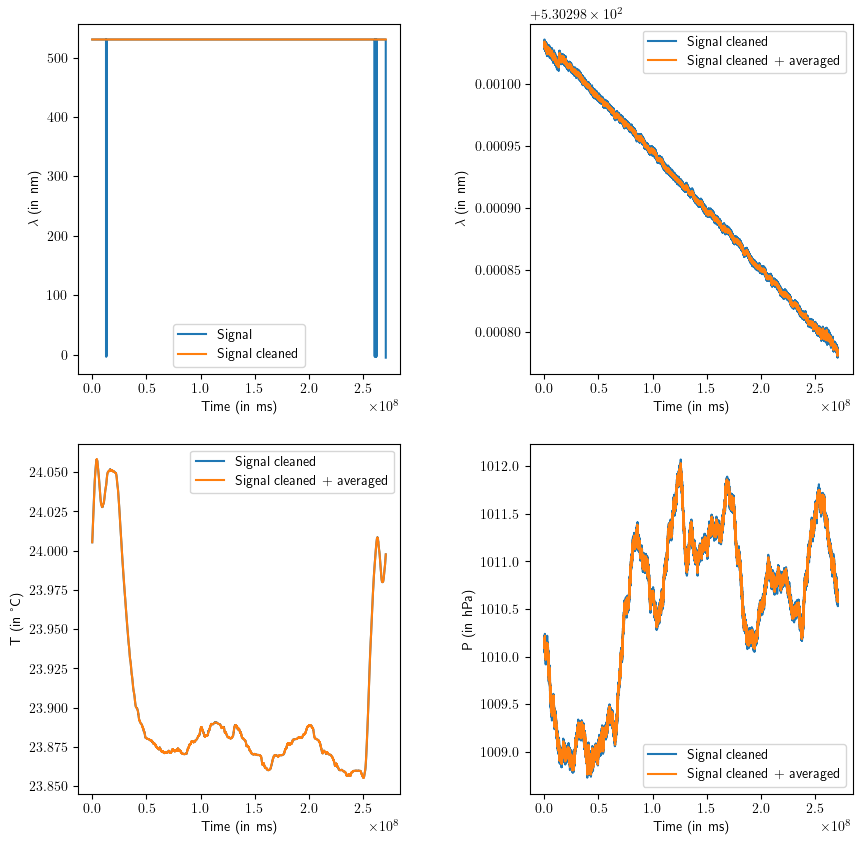

In [24]:
width_mean = int(1e1)
if len(Lambda_clean)%width_mean == 0: # No need to cut Lambda
    T_Mean = T_clean[::width_mean]
    Mean_Lambda = np.mean(np.reshape(Lambda_clean, (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    Temperature_mean = np.mean(np.reshape(Temperature_clean, (len(Temperature_clean)//width_mean, width_mean)), axis=1)
    Pressure_mean = np.mean(np.reshape(Pressure_clean, (len(Pressure_clean)//width_mean, width_mean)), axis=1)
else:
    T_Mean = T_clean[:-(len(Lambda_clean)%width_mean):width_mean]
    Mean_Lambda = np.mean(np.reshape(Lambda_clean[:-(len(Lambda_clean)%width_mean)], (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    Temperature_mean = np.mean(np.reshape(Temperature_clean[:-(len(Temperature_clean)%width_mean)], (len(Temperature_clean)//width_mean, width_mean)), axis=1)
    Pressure_mean = np.mean(np.reshape(Pressure_clean[:-(len(Pressure_clean)%width_mean)], (len(Pressure_clean)//width_mean, width_mean)), axis=1)

%matplotlib inline
plt.close()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.4)
axes[0, 0].plot(T, Lambda, label="Signal")
axes[0, 0].plot(T_clean, Lambda_clean, label="Signal cleaned")
axes[0, 0].legend()
axes[0, 0].set_xlabel("Time (in ms)")
axes[0, 0].set_ylabel(r"$\lambda$ (in nm)")

axes[0, 1].plot(T_clean, Lambda_clean, label="Signal cleaned")
axes[0, 1].plot(T_Mean, Mean_Lambda, label="Signal cleaned + averaged")
axes[0, 1].legend()
axes[0, 1].set_xlabel("Time (in ms)")
axes[0, 1].set_ylabel(r"$\lambda$ (in nm)")

axes[1, 0].plot(T_clean, Temperature_clean, label="Signal cleaned")
axes[1, 0].plot(T_Mean, Temperature_mean, label="Signal cleaned + averaged")
axes[1, 0].legend()
axes[1, 0].set_xlabel("Time (in ms)")
axes[1, 0].set_ylabel("T (in °C)")

axes[1, 1].plot(T_clean, Pressure_clean, label="Signal cleaned")
axes[1, 1].plot(T_Mean, Pressure_mean, label="Signal cleaned + averaged")
axes[1, 1].legend()
axes[1, 1].set_xlabel("Time (in ms)")
axes[1, 1].set_ylabel("P (in hPa)")
plt.show()

# FFT cleaned signal (not averaged)

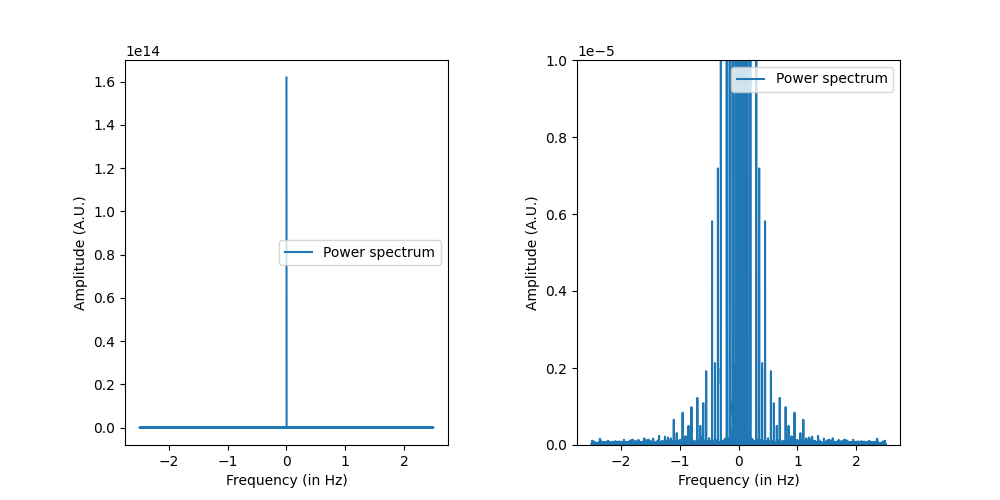

In [7]:
FT_Lambda_clean = np.fft.fft(Lambda_clean) # In nm.s
fs = 1e3*(len(T_clean)-1)/T_clean[-1] # In Hz
Freq = np.fft.fftfreq(len(T_clean), d=1/fs)

%matplotlib widget
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)
axes[0].plot(Freq, np.abs(FT_Lambda_clean)**2, label="Power spectrum")
axes[0].legend()
axes[0].set_xlabel("Frequency (in Hz)")
axes[0].set_ylabel("Amplitude (A.U.)")

axes[1].plot(Freq, np.abs(FT_Lambda_clean)**2, label="Power spectrum")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")
axes[1].set_ylim(0, 1e-5)
plt.show()

# FFT cleaned signal (not averaged) without the offset

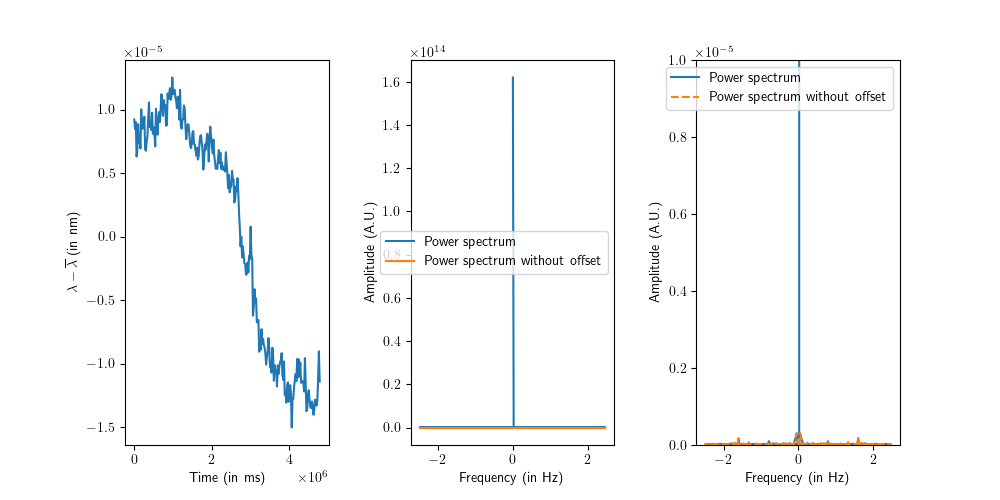

In [8]:
Lambda_clean_no_offset = Lambda_clean - np.mean(Lambda_clean)
FT_Lambda_clean_no_offset = np.fft.fft(Lambda_clean_no_offset) # In nm.s
fs = 1e3*(len(T_clean)-1)/T_clean[-1] # In Hz
Freq = np.fft.fftfreq(len(T_clean), d=1/fs)
plot_step = 100 # Plot one point every plot_step

%matplotlib widget
plt.rcParams['text.usetex'] = True
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

axes[0].plot(T_clean[::plot_step], Lambda_clean_no_offset[::plot_step])
axes[0].set_xlabel("Time (in ms)")
axes[0].set_ylabel(r"$\lambda - \overline{\lambda}$ (in nm)")

axes[1].plot(Freq[::plot_step], np.abs(FT_Lambda_clean[::plot_step])**2, label="Power spectrum")
axes[1].plot(Freq[::plot_step], np.abs(FT_Lambda_clean_no_offset[::plot_step])**2, label="Power spectrum without offset")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")

axes[2].plot(Freq[::plot_step], np.abs(FT_Lambda_clean[::plot_step])**2, label="Power spectrum")
axes[2].plot(Freq[::plot_step], np.abs(FT_Lambda_clean_no_offset[::plot_step])**2, label="Power spectrum without offset", linestyle = "--")
axes[2].legend()


axes[2].set_xlabel("Frequency (in Hz)")
axes[2].set_ylabel("Amplitude (A.U.)")
axes[2].set_ylim(0, 1e-5)
# axes[2].set_xlim(-1e-2, 1e-2)
plt.show()

# FFT on averaged clean signal

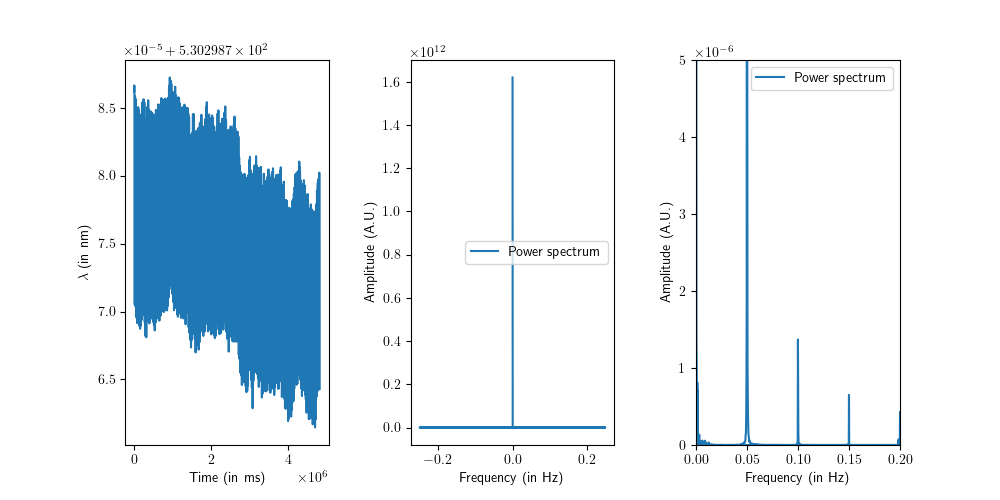

In [9]:
FT_Lambda_mean = np.fft.fft(Mean_Lambda) # In nm.s
fs_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_mean)

%matplotlib widget
plt.rcParams['text.usetex'] = True
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

axes[0].plot(T_Mean, Mean_Lambda)
axes[0].set_xlabel("Time (in ms)")
axes[0].set_ylabel(r"$\lambda$ (in nm)")

axes[1].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label="Power spectrum")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")

axes[2].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label="Power spectrum")
axes[2].legend()
axes[2].set_xlabel("Frequency (in Hz)")
axes[2].set_ylabel("Amplitude (A.U.)")
axes[2].set_ylim(0, 5e-6)
# axes[2].set_ylim(0, 1e-20)
axes[2].set_xlim(0, 2e-1)
plt.show()

# Compare frequencies Lambda/Temperature/power averaged

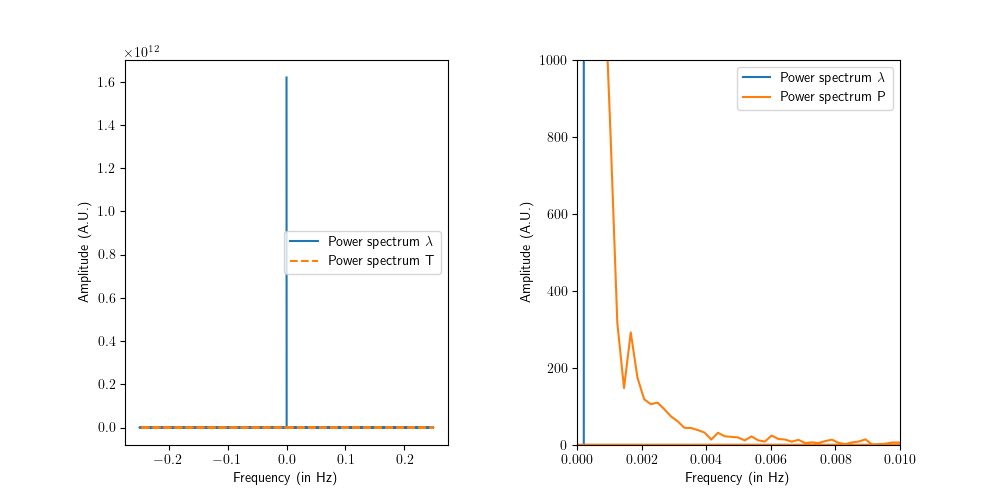

In [10]:
FT_temperature_mean = np.fft.fft(Temperature_mean) # In °C
fs_temperature_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_temperature_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_temperature_mean)

FT_pressure_mean = np.fft.fft(Pressure_mean) # In °C
fs_pressure_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_pressure_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_pressure_mean)

%matplotlib widget
plt.rcParams['text.usetex'] = True
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

axes[0].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label=r"Power spectrum $\lambda$")
axes[0].plot(Freq_temperature_mean, np.abs(FT_temperature_mean)**2, label="Power spectrum T", linestyle="--")
axes[0].legend()
axes[0].set_xlabel("Frequency (in Hz)")
axes[0].set_ylabel("Amplitude (A.U.)")
#axes[0].set_ylim(0, 1e-1)
# axes[0].set_xlim(0, 1e-2)

axes[1].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label=r"Power spectrum $\lambda$")
axes[1].plot(Freq_pressure_mean, np.abs(FT_pressure_mean)**2, label="Power spectrum P")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")
axes[1].set_ylim(0, 1e3)
axes[1].set_xlim(0, 1e-2)
plt.show()

# Compare normalized frequencies Lambda/Temperature/power averaged

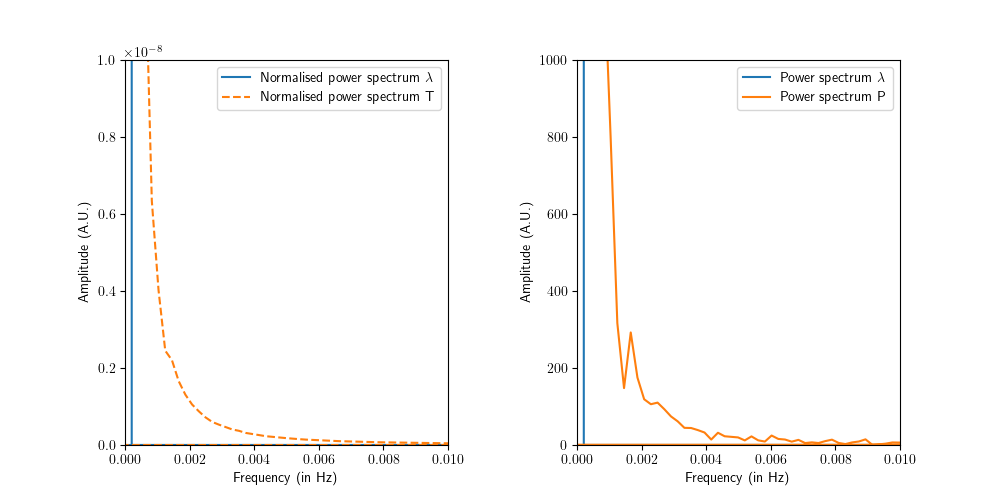

In [11]:
FT_temperature_mean = np.fft.fft(Temperature_mean) # In °C
fs_temperature_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_temperature_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_temperature_mean)

FT_pressure_mean = np.fft.fft(Pressure_mean) # In °C
fs_pressure_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_pressure_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_pressure_mean)

%matplotlib widget
plt.rcParams['text.usetex'] = True
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

axes[0].plot(Freq_mean, np.abs(FT_Lambda_mean)**2/np.max(np.abs(FT_Lambda_mean)**2), label=r"Normalised power spectrum $\lambda$")
axes[0].plot(Freq_temperature_mean, np.abs(FT_temperature_mean)**2/np.max(np.abs(FT_temperature_mean)**2), label="Normalised power spectrum T", linestyle="--")
axes[0].legend()
axes[0].set_xlabel("Frequency (in Hz)")
axes[0].set_ylabel("Amplitude (A.U.)")
axes[0].set_ylim(0, 1e-8)
axes[0].set_xlim(0, 1e-2)

axes[1].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label=r"Power spectrum $\lambda$")
axes[1].plot(Freq_pressure_mean, np.abs(FT_pressure_mean)**2, label="Power spectrum P")
axes[1].legend()
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")
axes[1].set_ylim(0, 1e3)
axes[1].set_xlim(0, 1e-2)
plt.show()

# Autocorrelations

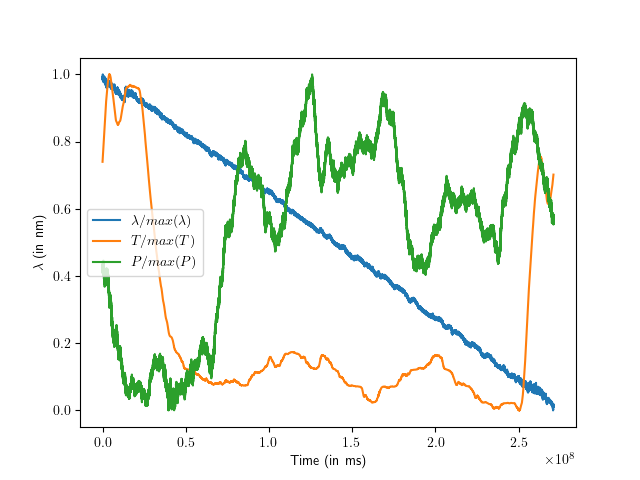

In [28]:
# Normalise the different datasets
Norm_Lambda = (Mean_Lambda-min(Mean_Lambda))/(max(Mean_Lambda)-min(Mean_Lambda))
Norm_Temperature = (Temperature_mean-min(Temperature_mean))/(max(Temperature_mean)-min(Temperature_mean))
Norm_Pressure = (Pressure_mean-min(Pressure_mean))/(max(Pressure_mean)-min(Pressure_mean))
plot_step = 1


%matplotlib widget
plt.close("all")
plt.figure()
plt.plot()

plt.plot(T_Mean[::plot_step], Norm_Lambda[::plot_step], label=r"$\lambda/max(\lambda)$")
plt.plot(T_Mean[::plot_step], Norm_Temperature[::plot_step], label=r"$T/max(T)$")
plt.plot(T_Mean[::plot_step], Norm_Pressure[::plot_step], label=r"$P/max(P)$")

plt.xlabel("Time (in ms)")
plt.ylabel(r"$\lambda$ (in nm)")
plt.legend()
plt.show()

In [29]:
Autocorr_lambda = np.correlate(Mean_Lambda, Mean_Lambda, mode="full")
Autocorr_temperature = np.correlate(Mean_Lambda, Mean_Lambda, mode="full")
Autocorr_pressure = np.correlate(Mean_Lambda, Mean_Lambda, mode="full")

%matplotlib widget
plt.close()
plt.figure()
plt.plot(Autocorr_lambda)
plt.plot(Autocorr_temperature)
plt.plot(Autocorr_pressure)
plt.show()

KeyboardInterrupt: 

# Brouillons

In [14]:
# """ Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
# and m the nbr of datapoints from a python readout of the WLM """
# def ReadDataPythonReadOut(path_name):
#     with open(path_name, 'r') as file:
#         Data = file.read()

#     Data = Data.split("\n")

#     # Initialize
#     res = np.zeros((len(Data[0].split(" ")), len(Data)))
#     try:
#         res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
#     except: # If error in reading (not everything is measured), return nothing
#         print("Error initialization")
#         return res

#     # Import the data line by line
#     for i in range(1, len(Data)):
#         try:
#             res[:, i] = np.array(Data[i].split(" "), dtype=float)
#             if res[0, i] < res[0, i-1]: # Time is not increasing
#                 res[0, i] = -1
#                 print("Time problem line "+str(i))
#         except: # If error in reading (not everything is measured), put -1 for the time
#             print("Error line "+str(i))
#             res[0, i] = -1
#     return res


# # Check that there is no time issue
# DeltaT = T[1:]-T[0:-1]
# CheckDeltaT = np.concatenate(([True], DeltaT>0))
# T, Lambda, Pressure, Temperature = T[CheckDeltaT], Lambda[CheckDeltaT], Pressure[CheckDeltaT], Temperature[CheckDeltaT]

# FT_Lambda = sc.fft.fft(Lambda_clean*1e-9) # In m
# t_step = np.mean(T[1:]-T[:-1])*1e-3 # In s
# Freq = sc.fft.fftfreq(len(T_clean), t_step)[:len(T_clean)//2]


# %matplotlib widget
# plt.close()
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# fig.subplots_adjust(wspace=0.4)
# axes[0].plot(Freq, np.abs(FT_Lambda[:len(T_clean)//2])**2, label="Power spectrum")
# axes[0].legend()
# axes[0].set_xlabel("Frequency (in Hz)")
# axes[0].set_ylabel("Amplitude (A.U.)")

# axes[1].plot(Freq, np.abs(FT_Lambda[:len(T_clean)//2])**2, label="Power spectrum")
# axes[1].legend()
# axes[1].set_xlabel("Frequency (in Hz)")
# axes[1].set_ylabel("Amplitude (A.U.)")
# axes[1].set_ylim(0, 1e-24)
# plt.show()